## **Table of Contents** 
* ** [Exploratory data analysis](#Exploratory-data-analysis)**
    + Read in data to a Pandas dataframe and inspect the features
    + Feature correlation visualisation
* ** [Data cleaning and feature engineering](#Data-cleaning-and-feature-engineering)**
    + Dealing with missing values and dropping unwanted features
    + Converting categorical features to numerical representations
    + Assigning continuous features to discrete bins
    + Extracting new features
* ** [Training ML algorithms to predict survival with scikit-learn](#Training-ML-algorithms-to-predict-survival-with-scikit-learn)**
    + K-fold cross validation to train the optimal classification algorithm
    + What is XGBoost and how does it work?
    + Feature importance
    + Hyperparameter tuning with GridSearch CV
* ** [Model evaluation](#Model-evaluation) **
    + Learning curves: bias vs variance
    + Confusion matrix
    + Precision vs recall
    + Precision/recall trade off
    + ROC-AUC 
* ** [Submission](#Submission) **
* ** [Conclusions](#Conclusions) **

# The Titanic dataset and binary classification challenge


In this challenge we're provided with some tabulated data about passengers on the RMS Titanic and how they faired in the infamous maritime disaster. The challenge is to explore the data, identify and prepare predictive features correlating with survival probability and train a binary classifier to successfully predict survival in an unlabelled dataset, using those features. 

# Exploratory data analysis

## Read in data to a Pandas dataframe and inspect the features
We are provided with passenger manifest data from the Titanic in two csv files. A train.csv file containing features and survival target label and a test.csv with features but no survival column. Firstly, I should read in the data to a pandas dataframe to allow me to explore and manipulate the data effectively.

In [1]:
# Load dependencies

import pandas as pd    # data cleaning and preparation
import numpy as np     # arrays, linear algebra 
import matplotlib.pyplot as plt  #visualisation libraries
import seaborn as sns    #pretty plots by default
import re              # regular expressions for pattern matching in strings

sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=2)
%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
#Read in the titanic survival dataset CSV files

df_train = pd.read_csv('/Users/constar/Downloads/titanic_end2end/train.csv')
df_test = pd.read_csv('/Users/constar/Downloads/titanic_end2end/test.csv')

In [3]:
#Take a look at the training data frame 
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Use df.info() to get a count of the non-null rows in each column. We can also see the data type of each column
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
#Use df.describe() to see a summary statistics table for the dataframe

df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* From the df.describe() output we see that the mean for the survived column (0 = died, 1 = survived) is 0.38, therefore a mere 38% of the passengers in the training set survived. The two classes in our target variable are not evenly distributed in the data, something to consider during modelling.

* If the test set features are similarly distributed to the training set, a predictor predicting death no matter the input feature values would be 62% accurate

* We can also see the count, mean, std, min and max values for the various features giving a sense of their distributions

* Looks like we have some missing values in the Age and Cabin columns in the training set, which will have to be dealt with before model building

* Many of the feature columns are categorical variables which will need to be converted to numerically encoded representations in order to feed them into machine learning models in sklearn

## Feature correlation visualisation
By plotting features against the target label we draw some initial conclusions about the correlation between the existing numerical features and survival.

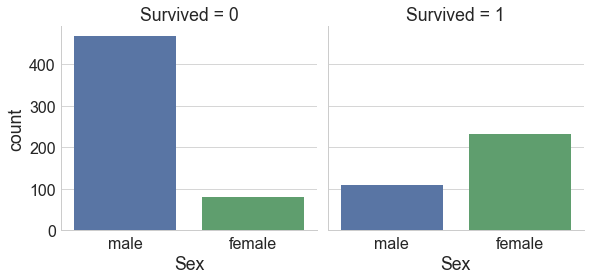

In [6]:
# More women surived than men
sns.factorplot(x='Sex', col='Survived', kind='count', data=df_train);

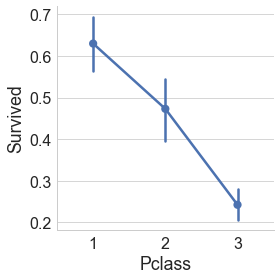

In [7]:
# First class passengers > second class passengers > third class passengers, in percentage survival
sns.factorplot('Pclass','Survived', data=df_train)

In [8]:
# The bulk of the dead were men in Pclass 3
pd.crosstab([df_train.Sex, df_train.Survived], df_train.Pclass, margins=True).style.background_gradient(cmap='winter_r')

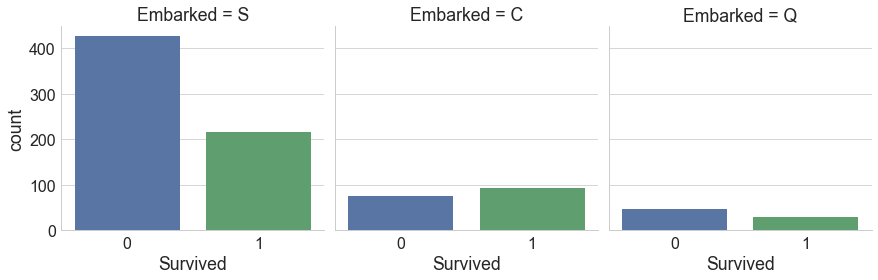

In [9]:
# More people embarked at S than the other ports and the majority of those embarking at S died
sns.factorplot(x='Survived', col='Embarked', kind='count', data=df_train);

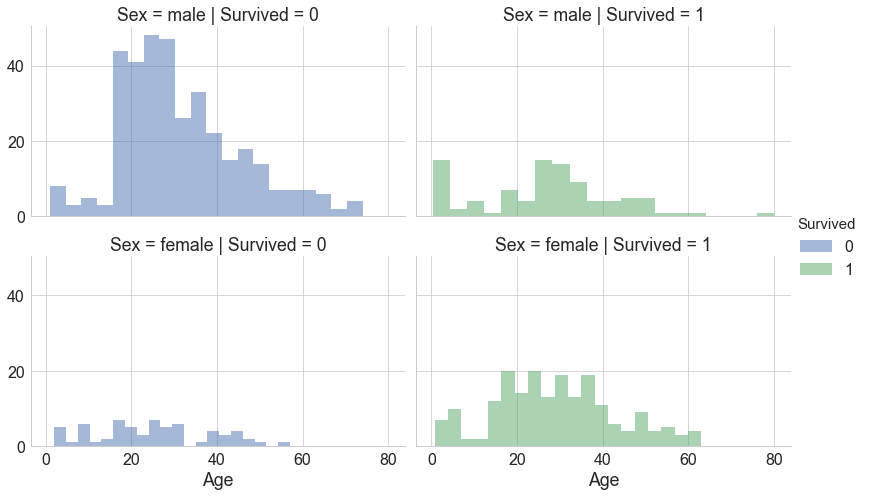

In [10]:
# Most of the men who died were in their prime, between 18-40
grid = sns.FacetGrid(df_train, col='Survived', row='Sex', size=3.5, aspect=1.6, hue = 'Survived')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

Looking at the correlation matrix, Pclass and Fare are most clearly correlated with survival whilst Age, SibSp(no. siblings or spouse) and Parch (number of parents or children aboard) also show some correlation

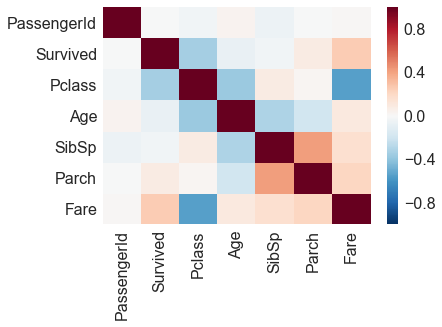

In [11]:
# df.corr() calculates Pearsons correlation coefficient by default for each feature pair and target-feature pair
corr = df_train.corr()
sns.heatmap(corr, cmap = 'RdBu_r', center = 0)

So it looks like Sex, Pclass, Fare, Age, Parch, SibSp and Embarked are useful predictive features. 
It's possible that the Name and Cabin information could also be useful but work needs to be done to extract the useful content from these columns (i.e title and deck) and then encode them numerically.

# Data cleaning and feature engineering

Here I will drop unwanted features, deal with missing values, encode categorical variables as numerics, assign continuous variables to discrete bins and generate new features. All transformations have to be carried out on both training and testing data in order to train the model and generate the predictions for Kaggle submission.

## Dealing with missing values and dropping unwanted features

In [12]:
# Drop the passenger ID and Ticket columns, they're unlikely to have any predictive utility

df_train = df_train.drop(['PassengerId', 'Ticket'], axis = 1)
df_test = df_test.drop(['Ticket'], axis = 1)

Time to address the missing values in the Age column, which will caused problems for sklearn using .fillna(method ="ffil") substitutes the empty values with the last value and in this way doesn't effect the distribution, provided empty Age values aren't located next to one another

In [13]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

## Converting categorical features to numerical representations

Let's convert the Sex column from categorical to a one-hot encoded numeric representation, as dtype int64, so that sklearn can work with it

In [14]:
df_train.Sex = df_train.Sex.map({'male':0, 'female':1}).astype(int)
df_test.Sex = df_test.Sex.map({'male':0, 'female':1}).astype(int)

In [15]:
df_train.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

Convert the embarked column to a numeric mapping

In [16]:
data = [df_train, df_test]

for dataset in data:
    dataset.Embarked = dataset.Embarked.map({'S':0, 'C':1, 'Q':2}).astype(int)

## Assigning continuous features to discrete bins

Now to decide upon suitable Age bins I'll have a look at the Age distribution

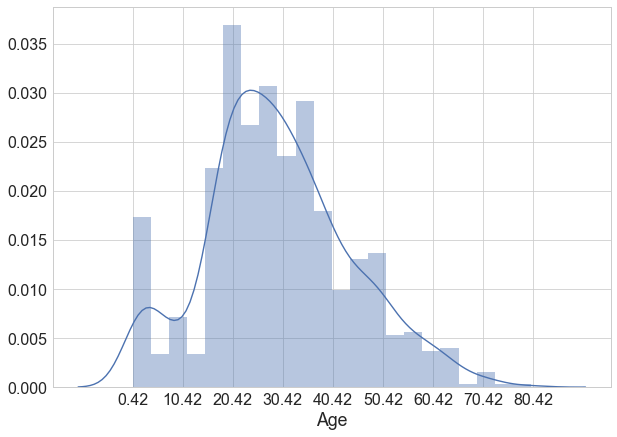

In [17]:
plt.subplots(figsize=(10,7))
plt.xticks(np.arange(min(df_train.Age), max(df_train.Age)+1, 10.0))
sns.distplot(df_train.Age)

The Age feature is somewhat normally distributed/slightly bimodal so I'll just assign the ages to 8 evenly spaced bins

In [18]:
data = [df_train, df_test]

for df in data:
    df['Age_bin']=np.nan
    for i in range(8,0,-1):
        df.loc[df['Age'] <= i*10, 'Age_bin'] = i

In [19]:
data = [df_train, df_test]

for df in data:
    df_train.Age_bin = df_train.Age_bin.astype(int)
    df_test.Age_bin = df_test.Age_bin.astype(int)

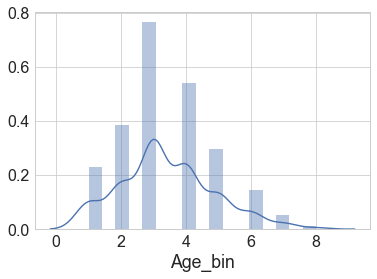

In [20]:
sns.distplot(df_train.Age_bin)

Time to assign the Fare values to suitable bins

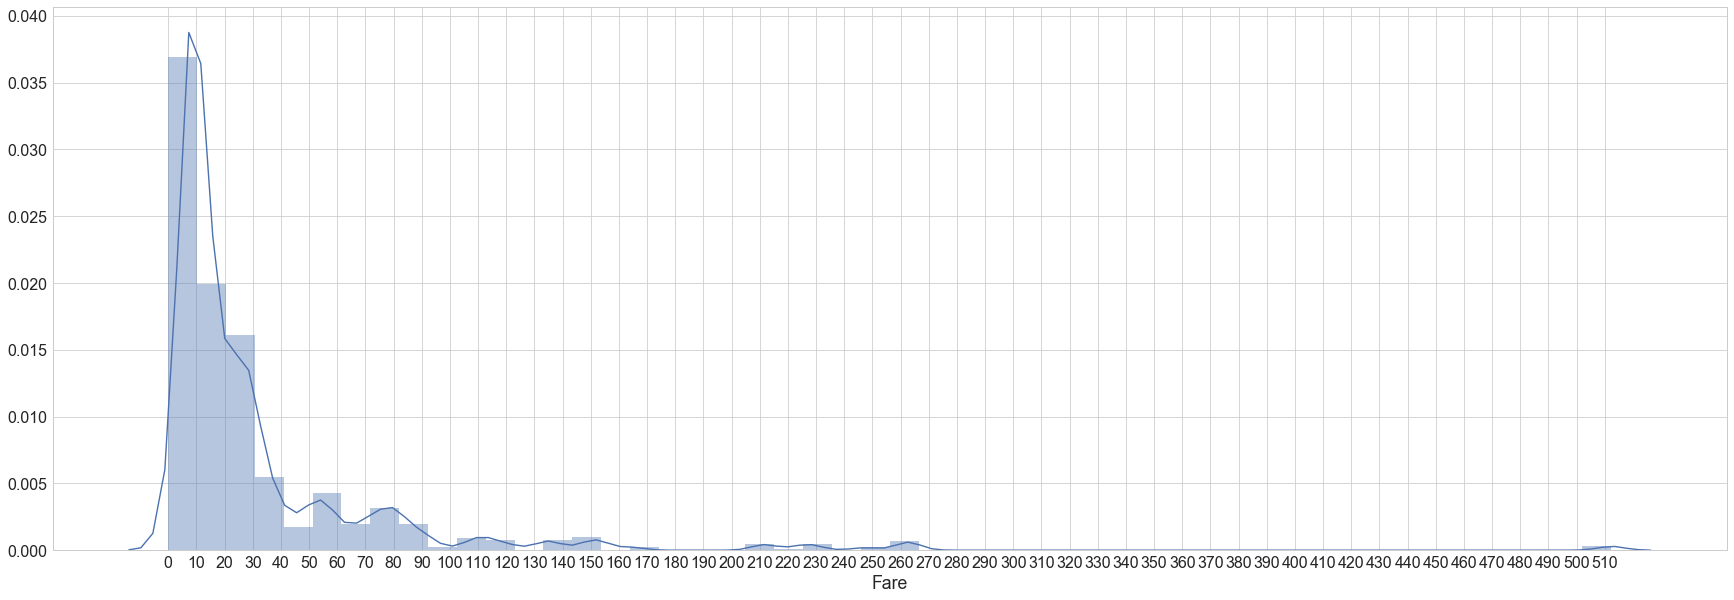

In [21]:
# Plot the Fares to take a look at their distributions
plt.subplots(figsize=(30,10))
plt.xticks(np.arange(min(df_train.Fare), max(df_train.Fare)+1, 10.0))
sns.distplot(df_train.Fare)

In [22]:
# Based on the distribution of the Fares, assign them to the following bins corresponding to roughly each peak in 
# the distplot kde profile (gaussian kernel density estimate) in an attempt to capture the distribution
data = [df_train, df_test]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 5, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 5) & (dataset['Fare'] <= 10), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 20), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 20) & (dataset['Fare'] <= 40), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 40) & (dataset['Fare'] <= 99), 'Fare']   = 4
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 180), 'Fare']   = 5
    dataset.loc[(dataset['Fare'] > 180) & (dataset['Fare'] <= 280), 'Fare']   = 6
    dataset.loc[ dataset['Fare'] > 280, 'Fare'] = 7
    dataset['Fare'] = dataset['Fare'].astype(int)

## Extracting new features

Use regular expressions to extract the Title and deck number from the Name and Cabin columns respectively and assign them one hot encodings

In [23]:
data = [df_train, df_test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # use the regex ' ([A-Za-z]+)\.' to extract the titles from the names
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Assign rare titles as Rare and convert Mme and Ms to the more common Mrs and Miss 
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # fill NaN with 0 to keep the dimensions the same as the other features
    dataset['Title'] = dataset['Title'].fillna(0)

# Extract the Deck feature from the Cabin column    
    
deck = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6,'G':7,'U':8}    
    
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('U0')
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile('([a-zA-Z]+)').search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

Create a not_alone binary feature. Perhaps those with families were more likely to survive, as Parch and SibSp were both positively correlated with survival.

In [24]:
data = [df_train, df_test]
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['Relatives']>0, 'not_alone'] = 0
    dataset.loc[dataset['Relatives']== 0 , 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

Males in Pclass 3 didn't fair well on the Titanic based on the plots above, so I'll generate an indicator variable to capture this correlation.

In [25]:
data = [df_train, df_test]

for dataset in data:
    dataset['Male_P3'] = (dataset['Sex'] == 0) & (dataset['Pclass'] == 3).astype(int)


Multiplying features together, generates new features which may be useful. Age and Pclass showed the same correlation with Survival, perhaps multiplying them together will amplify their contribution to the classifers I'm about to train

In [26]:
data = [df_train, df_test]
for dataset in data:
    dataset['Age_Class']= dataset['Age_bin']* dataset['Pclass']

Fare per person is an additional socio-economic indicator derived from the Fare and Relatives features, which correlates positively with Survival

In [27]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['Relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [28]:
# Now drop the old continuous or text features which aren't required
data = [df_train, df_test]

for dataset in data:
    dataset.drop(['Age','Name', 'Cabin'],axis=1,inplace=True)

Plotting the correlation matrix now that feature engineering is complete shows how much additional predictive signal we have generated ready for modelling

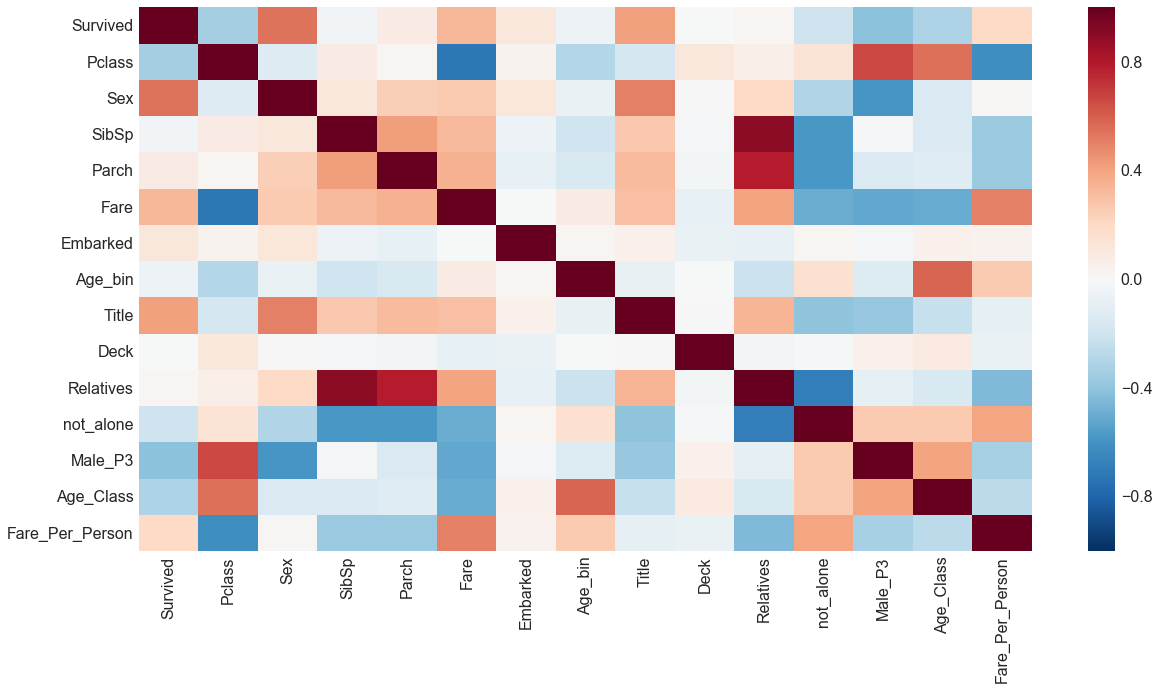

In [29]:
plt.subplots(figsize=(20,10))
corr = df_train.corr()
sns.heatmap(corr, cmap = 'RdBu_r', center = 0)

# Training ML algorithms to predict survival with scikit-learn

In [30]:
# Prepare dataframes for sklearn, so that the feature columns and target label are in separate dataframes
X_training = df_train.drop('Survived', axis = 1).copy()
y_training = df_train.Survived

Time to raid the sklearn library for some suitable classification algorithms, training tools and validatory metrics. For the binary classification task of predicting survival based on several features we could try some classic classifiers such as: support vector classifier, decision tree, random forests, K nearest neighbors and logistic regression.

Also worth trying are classifiers from the ensemble module of sklearn which implement tree "boosting", such as: adaptive boosting (AdaBoost), gradient boosting, exta trees and extreme gradient boosting (XGBoost) classifiers. 

In [31]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, StratifiedShuffleSplit

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


I could perform a train test split of the training dataframe using train_test_split....

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('Survived',axis=1),
                                                    df_train['Survived'], test_size=0.2, random_state=2)

...then train each classifier using the X_train and y_train subsets...

In [33]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

... and then assess the performance of the classifier against the test set, which the classifier hasn't been trained on, hopefully giving a sensible estimate of the classifier's out of sample performance via sklearn's accuracy score, which is just the fraction of correct predictions.

![accuracy_score](http://scikit-learn.org/stable/_images/math/cd4bea15b385d15cceb8e24f68976da7d8510290.png)

In [34]:
rfc_prediction = rfc.predict(X_test) 
accuracy_score(rfc_prediction, y_test)

0.79329608938547491

## K-fold cross validation to train the optimal classification algorithm

However, in order to make the most out of the training data available, maximising the amount of signal gathered from each feature, a better way to train and assess the classifier is via cross validation, a process of iteratively splitting the training data into different training and testing sets so that all of the data is used to both train and test the classifier, taking an average of the performance to give a more realistic impression of the model's performance. This also provides a more reliable accuracy metric by which to compare rival algorithms on a given problem.

The image below illustrates the process of splitting a dataset into K-folds (K = 5) for cross validation.

![cv](http://tomaszkacmajor.pl/wp-content/uploads/2016/05/cross-validation.png)

https://www.edureka.co/blog/implementation-of-decision-tree/

To ensure the cross validation folds are not derived from chunks of the dataset which are unrepresentative of the distributions seen in the dataset as a whole, shuffling and stratification can be specified in the cross validation options.

In [35]:
# stratified shuffle split of the data into 10 folds, with 20% of the data used in testing
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=2)

Using the cell below I can perform the same training and testing as outlined above using train_test_split but instead training and testing on all available data via cross validation, whilst testing multiple classifiers in parallel.

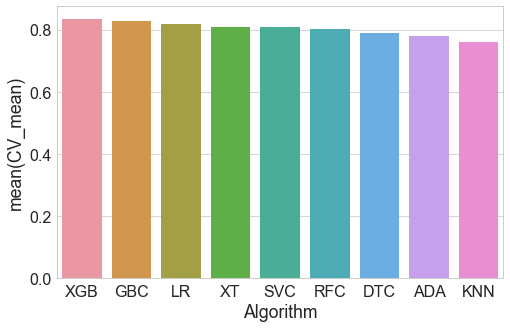

In [36]:
random_state=2

# store all the classifiers in a list
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))

# store the cross validation accuracy results in a list
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(estimator=classifier,X=X_training,y=y_training,
                                      cv=sss,scoring='accuracy', n_jobs=-1))

# store the mean accuracy and standard deviation of the accuracy for each cross validation fold in lists    
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

# Combine the results lists in a dataframe
cv_results=pd.DataFrame({'CV_mean':cv_means , 'CV_std':cv_std , 'Algorithm':['SVC','DTC','RFC','KNN','LR',
                                                                             'ADA','XT','GBC','XGB']})
# sort the results by score
cv_results = cv_results.sort_values('CV_mean',ascending=False)

# plot the values for swift visual assessment of classifier performance
plt.subplots(figsize=(8,5))
sns.barplot('Algorithm','CV_mean',data=cv_results)

Looks like XGBoost gives the best mean accuracy score from cross validation

In [37]:
cv_results

,Algorithm,CV_mean,CV_std
8,XGB,0.832961,0.012354
7,GBC,0.828492,0.014579
4,LR,0.818994,0.014177
6,XT,0.809497,0.023892
0,SVC,0.808939,0.026180
2,RFC,0.800559,0.017137
1,DTC,0.787709,0.023702
5,ADA,0.778771,0.019704
3,KNN,0.758659,0.023007


# What is XGBoost and how does it work?

Decision tree classifiers are supervised machine learning algorithms, which are trained by maximising the separation of classes achieved by decision bounderies in labelled data and thereby allow you to classify previously unseen data. XGBoost is a **tree ensemble** based classification algorithm which uses many shallow decision trees to classify the input features, which individually are only slightly better than random guessing. These are  known as **weak learners** and have **high bias and low variance**. The predictions of these weak learners are summed to give an overall prediction for a given test example's set of feature values, in a similar manner to a random forest classifier but with much shallower trees. The tree boosting of XGBoost refers to the **minimisation of the bias** of the model, by optimisation of the individual tree structures (number of leaves) over many boosting steps, with each step attempting to add a new tree to the model.

TL;DR

XGBoost is a tree boosting alogrithm using ensembles of shallow decision trees.

![decisiontreeforest](http://cdn-ak.f.st-hatena.com/images/fotolife/T/TJO/20150603/20150603222152.png)

http://tjo-en.hatenablog.com/entry/2015/06/04/190000

The weak learners work something like the diagram from the XGBoost documentation below. A given tree in the model will be optimised to draw decision boundaries through distributions of the features I've engineered, which maximise the separation of the Survived 0 and 1 classes. The scores for a given terminal node, will then be based on the probability that an example satisfying that criteria/threshold, belongs to either the Survived = 0 or Survived = 1 class. The scores for all the trees are combined to generate a prediction for a given testing example's set of feature values. The boosting procedure optimises the number of trees, leaf scores and structure of these trees, to minimise the classifier's bias and maximise it's predictive accuracy.

![weaklearners](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png)

A detailed description of XGBoost is given here http://xgboost.readthedocs.io/en/latest/model.html

In [38]:
xgbc = XGBClassifier(random_state=random_state)
xgbc.fit(X_training, y_training)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [39]:
scores = cross_val_score(xgbc, X_training, y_training, cv=sss, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


Scores: [ 0.84357542  0.82122905  0.82681564  0.8603352   0.83240223  0.82122905
  0.83240223  0.83798883  0.81564246  0.83798883]
Mean: 0.832960893855
Standard Deviation: 0.0123538236802


The XGBoost classifier has a mean CV accuracy of 83.07% on the training data with default parameters. This can be improved by tweaking features and model parameters.

## Feature importance

Which of the features I engineered is XGBoost using most effectively to generate trees which minimise it's error function?

In [40]:
importances = pd.DataFrame({'feature':X_training.columns,'importance':np.round(xgbc.feature_importances_,3)})

importances = importances.sort_values('importance',ascending=False).set_index('feature')


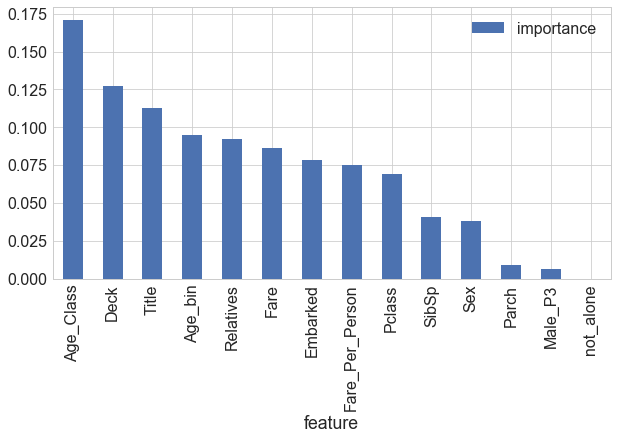

In [41]:
importances.plot.bar(figsize=(10,5))

If I drop a few of the less important features will the cv accuracy increase? Will I increase the overall signal to noise of my predictive features?

In [42]:
X_training = X_training.drop(['not_alone', 'Male_P3','Parch'], axis=1)

In [43]:
xgbc = XGBClassifier(random_state=random_state)
xgbc.fit(X_training, y_training)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [44]:
scores = cross_val_score(xgbc, X_training, y_training, cv=sss, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


Scores: [ 0.84916201  0.82122905  0.82681564  0.8547486   0.83798883  0.82122905
  0.83240223  0.83240223  0.81005587  0.8547486 ]
Mean: 0.834078212291
Standard Deviation: 0.0143630839466


Looks like dropping the **not_alone, Male_P3 and Parch** features improved the mean CV accuracy score slightly. 

## Hyperparameter tuning with GridSearch CV
Now to reduce overfitting by tuning the model parameters relevant to model complexity 

In [45]:
# GridSearch CV automatically tests a series of model parameters through the cross validation specified and outputs
# the parameters which generated the best cross validation score

params = {
          'max_depth' : range(3,10,1),       # maximum depth of the trees - deeper = more likely to overfit
          'min_child_weight' : range(1,5,1), # minimum child weight - The lower the more likely to overfit
          'gamma' : [1,2,3,4],               # gamma - regularisation parameter
         }

xgbc = XGBClassifier()

clf = GridSearchCV(estimator=xgbc, param_grid=params, cv = sss, n_jobs=-1)

clf.fit(X_training, y_training)

clf.best_params_

{'gamma': 2, 'max_depth': 8, 'min_child_weight': 2}

In [46]:
xgbc = XGBClassifier(random_state=random_state, gamma = 2, max_depth = 8, min_child_weight = 2)
xgbc.fit(X_training, y_training)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=2, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=2,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [47]:
scores = cross_val_score(xgbc, X_training, y_training, cv=sss, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [ 0.84916201  0.84916201  0.82681564  0.86592179  0.8603352   0.82122905
  0.82122905  0.87709497  0.81005587  0.83798883]
Mean: 0.841899441341
Standard Deviation: 0.0209105779578


So parameter tuning has also improved the mean cross validation accuracy of the classifier slightly. I can now generate some plots and other metrics to get a sense of how well the XGBoost classifier is working.

# Model evaluation

## Learning curves: bias vs variance


Error = Bias + Variance. Bias being the difference between predicitions and target labels and variance being the spread of predictions from each other.  Learning curves of error vs training set size can be used to assess the **bias and variance** of your model

![biasvariance](https://i.imgur.com/I1rzmAY.png?1)

Andrew Ng Stanford ML course slides

(-0.1, 1.1)

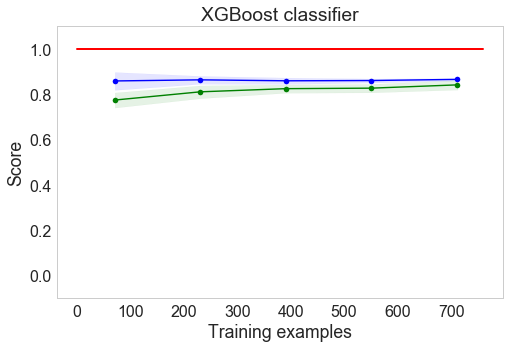

In [48]:
train_sizes, train_scores, test_scores = learning_curve(xgbc, X_training, y_training, n_jobs=-1, cv=sss, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

# calculate mean and standard deviation for training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# setup the plot
plt.figure(figsize = (8,5))
plt.title('XGBoost classifier')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot([1,760],[1,1], linewidth=2, color = 'r')

plt.grid()
    
# shade the area +/- one standard deviation of the mean scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
# plot the mean training and test scores vs training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.ylim(-.1,1.1)

Looking at my learning curve it looks like the the XGBoost classifier is definitely of the **high bias low variance** type. The curves are also quite flat suggesting adding more data is unlikely to improve performance substantially.

## Confusion matrix
The confusion matrix is a plot of the predictions generated by the classifier, separated into True predictions (true positives (TP) and true negatives (TN)) and False predictions (false positives (FP) and false negatives (FN)), allowing you to visualise which predictions your model is getting wrong most often

![confusion_matrix](http://revolution-computing.typepad.com/.a/6a010534b1db25970b01bb08c97955970d-pi)

http://revolution-computing.typepad.com/.a/6a010534b1db25970b01bb08c97955970d-pi

In the confusion matrix plot below you can see that the classifier predicts survived = 0 more than survived = 1 and the false positives and false negatives look comparatively low. Nevertheless it looks to have more false survived = 0 predictions than false survived = 1 predictions, perhaps due to the greater number of dead individuals in the training data.

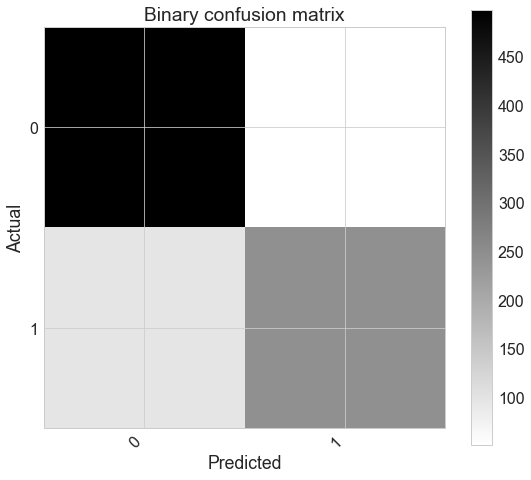

In [49]:
from sklearn.model_selection import cross_val_predict
from pandas_ml import ConfusionMatrix
predictions = cross_val_predict(xgbc, X_training, y_training, cv=10)
cm = ConfusionMatrix(y_training, predictions)
cm.plot()

## Precision and recall

Precision and recall are useful for assessing model performance in instances where the distributions of classes in the training data are imbalanced. 

Precision = of the times positive is predicted, what fraction of those predictions were correct (dependent on bias).


$$ Precision = \dfrac {TP} {TP+FP} $$ 

Recall = of the positive class examples present in the data, what fraction were predicted successfully (dependent on variance).


$$ Recall = \dfrac {TP} {TP+FN} $$

Precision and recall can be used to calculate the F1 score, the harmonic mean of precision and recall and another performance metric to look at:

$$ F1 = 2 * \dfrac {(Precision * Recall)} {(Precision + Recall)} $$

In [50]:
from sklearn.metrics import f1_score
f1_score(y_training, predictions)

0.76802507836990597

Plotting precision vs recall gives an idea of overall model performance. Curves for perfect binary classifiers shown below. Notice how the baseline model (50/50 random prediction of either class) shifts dependent on the distribution of classes in the dataset.

![precision_recall](https://classeval.files.wordpress.com/2015/06/perfect-precision-recall-curve1.png?w=840&h=448)

https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/

In [51]:
from sklearn.metrics import precision_recall_curve

# generate predictions from the training data
y_scores = xgbc.predict_proba(X_training)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_training, y_scores)

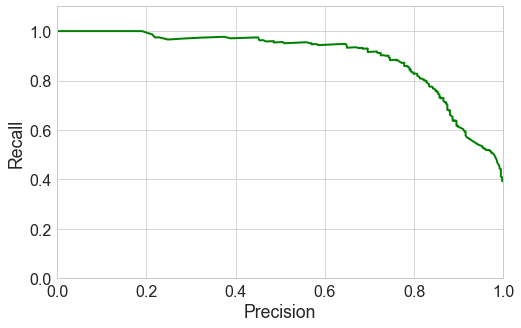

In [52]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g", linewidth=2)
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.axis([0, 1.5, 0, 1.5])
    plt.xlim(0,1)
    plt.ylim(0,1.1)
    
plt.figure(figsize=(8, 5))
plot_precision_vs_recall(precision, recall)

Looks like my classifier is not perfect but not too bad.

## Precision vs recall trade-off

Depending on the application of the classifier you may want to adjust the model for high precision lower recall or higher recall and lower precision. In this case I just want to make the most accurate predictor but if for example the consequences of subsequent decisions based on false positives were worse than false negatives, you would want to adjust the threshold to increase the precision at the expense of the recall of the classifier. You can calculate the precision and recall for a range of threshold values (cut off values generating a decision boundary between the two classes in the binary classifier) and plot them to visualise the precison/recall trade-off of the model.

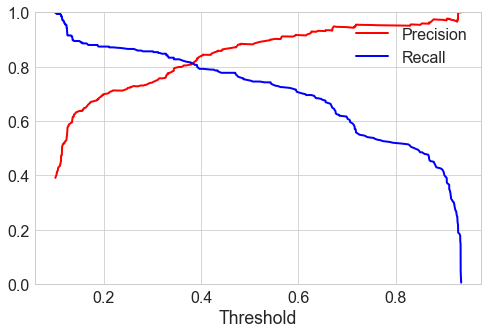

In [53]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="Precision", linewidth=2)
    plt.plot(threshold, recall[:-1], "b", label="Recall", linewidth=2)
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim([0, 1])

plt.figure(figsize=(8, 5))
plot_precision_and_recall(precision, recall, threshold)

Based on the curve above if a precision of ~90% was desired a threshold of 0.6 could be used, which would come at the cost of a recall of ~75%

## Reciever operator characteristic - area under curve (ROC AUC)
Another visualisation of model performance is the ROC curve, a plot of true positive rate vs false positive rate, which also gives you the ROC-AUC performance metric. A random classifier would give a plot like the red line whilst a perfect classifier would follow the green line.

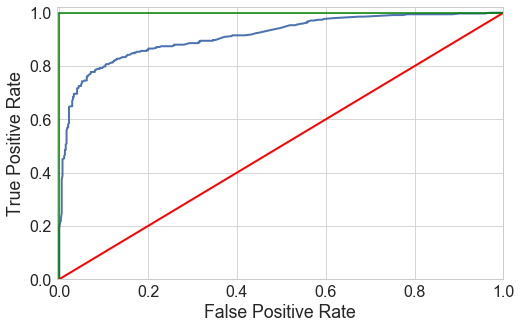

In [54]:
from sklearn.metrics import roc_curve

# calculate rates of false +ve and true +ve predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_training, y_scores)

def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=2)
    plt.plot([0, 1], [1, 1], 'g', linewidth=1.5)
    plt.plot([0, 0], [1, 0], 'g', linewidth=1.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim(0,1.02)
    plt.xlim(-0.005,1)

plt.figure(figsize=(8, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)

In [55]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(y_training, y_scores)
print("ROC-AUC Score:", r_a_score)

ROC-AUC Score: 0.913907796206


The curve looks to be closer to the top left hand corner than the red line and so the AUC score is close approaching 1. The classifier is doing a reasonable job!

# Submission

In [56]:
submission_testing = df_test.drop(['PassengerId','not_alone', 'Male_P3','Parch'], axis = 1).copy()
Y_prediction = xgbc.predict(submission_testing)

In [57]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_prediction
    })
submission.to_csv('/Users/constar/Desktop/submission.csv', index=False)

# Conclusions
Exploration of the data shows many features correlate with survival. Interestingly the XGBoost classifier which cross validation indicated was the most accurate algorithm, didn't rely heavily on all of the engineered features  according to the importance plot. The relatively low importance of the Sex feature, which seemed a very strongly correlated feature with survival was suprising. The accuracy of the XGBoost classifier I have trained could definitely be improved through systematic feature selection and parameter tuning. Nevertheless with the minimal tweaking demonstrated here it is reasonably accurate. 

** Many thanks to the countless Kaggle kernel authors and blog writers whose work helped me in developing this kernel.**